In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# Define data transformations (convert images to tensors & normalize)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize pixel values to [-1, 1]
])

# Download MNIST dataset
train_dataset = torchvision.datasets.MNIST(root="./data", train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root="./data", train=False, transform=transform, download=True)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [4]:
import torch.nn as nn
import torch.nn.functional as F

class MNIST_Net(nn.Module):
    def __init__(self):
        super(MNIST_Net, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)  # Input: 784 pixels → Hidden: 128 neurons
        self.fc2 = nn.Linear(128, 64)       # Hidden: 128 → Hidden: 64 neurons
        self.fc3 = nn.Linear(64, 10)        # Hidden: 64 → Output: 10 (digits 0-9)

    def forward(self, x):
        x = x.view(-1, 28*28)  # Flatten input image
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # No activation (logits for CrossEntropyLoss)
        return x

# Initialize model
model = MNIST_Net()
#model.load_state_dict(torch.load("model_weights.pth"))

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)



MNIST_Net(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

In [5]:
import torch.optim as optim

# Define loss function & optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 5
for epoch in range(epochs):
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # Move data to GPU

        optimizer.zero_grad()  # Reset gradients
        outputs = model(images)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

print("Training complete!")

# Save the model's state_dict
torch.save(model.state_dict(), "./model_weights.pth")


Epoch 1/5, Loss: 0.2838
Epoch 2/5, Loss: 0.1177
Epoch 3/5, Loss: 0.1469
Epoch 4/5, Loss: 0.0672
Epoch 5/5, Loss: 0.3254
Training complete!


In [6]:
correct = 0
total = 0

with torch.no_grad():  # Disable gradient calculations
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)  # Get predicted class
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")


Test Accuracy: 95.56%


In [7]:
total_weights = sum(p.numel() for name, p in model.named_parameters() if "weight" in name)
total_biases = sum(p.numel() for name, p in model.named_parameters() if "bias" in name)

print(f"Total Weights: {total_weights}")
print(f"Total Biases: {total_biases}")
print(f"Total Parameters: {total_weights + total_biases}")


Total Weights: 109184
Total Biases: 202
Total Parameters: 109386


109184


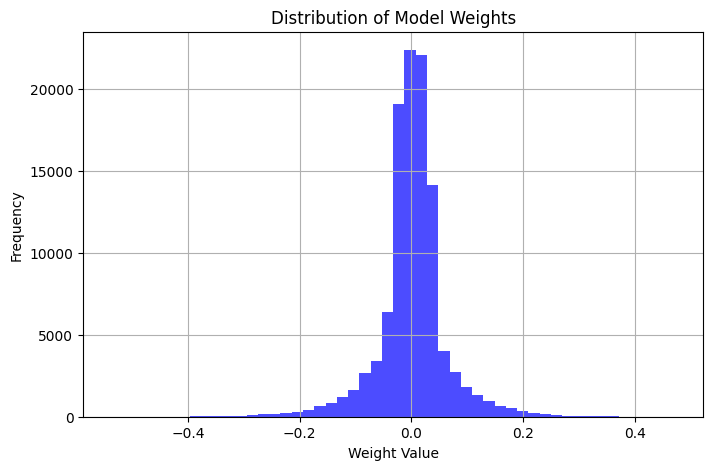

In [8]:
import matplotlib.pyplot as plt

# Get all weights as a flattened tensor
all_weights = torch.cat([param.view(-1) for name, param in model.named_parameters() if "weight" in name])
print(len(all_weights))

# Convert to NumPy for plotting
all_weights = all_weights.detach().cpu().numpy()

# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(all_weights, bins=50, alpha=0.7, color="blue")
plt.title("Distribution of Model Weights")
plt.xlabel("Weight Value")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


976


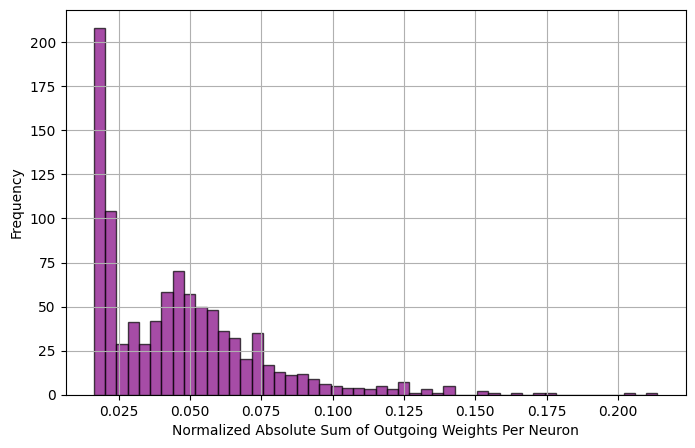

In [9]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Compute absolute sum of outgoing weights per neuron and normalize by the number of weights
fc1_outgoing = torch.sum(torch.abs(model.fc1.weight), dim=0) / model.fc1.weight.size(0)
fc2_outgoing = torch.sum(torch.abs(model.fc2.weight), dim=0) / model.fc2.weight.size(0)
fc3_outgoing = torch.sum(torch.abs(model.fc3.weight), dim=0) / model.fc3.weight.size(0)

# Combine all values
all_outgoing_sums = np.concatenate([fc1_outgoing.detach().cpu().numpy(), 
                                    fc2_outgoing.detach().cpu().numpy(), 
                                    fc3_outgoing.detach().cpu().numpy()])  # Total: 976 neurons
print(len(all_outgoing_sums))

# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(all_outgoing_sums, bins=50, alpha=0.7, color="purple", edgecolor="black")
plt.xlabel("Normalized Absolute Sum of Outgoing Weights Per Neuron")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


202


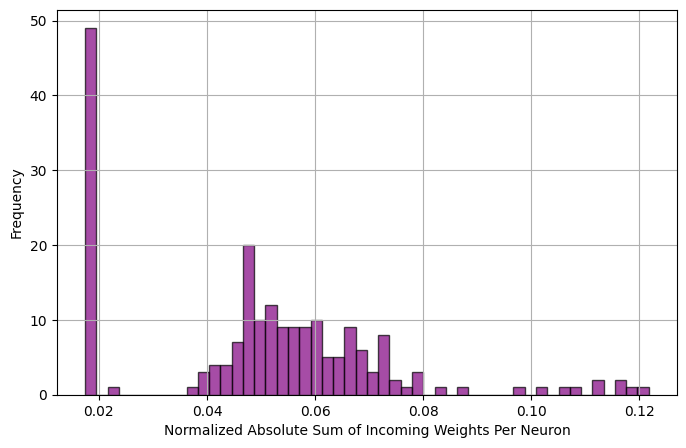

In [10]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Compute absolute sum of outgoing weights per neuron and normalize by the number of weights
fc2_incoming = torch.sum(torch.abs(model.fc2.weight), dim=1) / model.fc2.weight.size(1)
fc1_incoming = torch.sum(torch.abs(model.fc1.weight), dim=1) / model.fc1.weight.size(1)
fc3_incoming = torch.sum(torch.abs(model.fc3.weight), dim=1) / model.fc3.weight.size(1)

# Combine all values
all_incoming_sums = np.concatenate([fc1_incoming.detach().cpu().numpy(), 
                                    fc2_incoming.detach().cpu().numpy(), 
                                    fc3_incoming.detach().cpu().numpy()])  # Total: 976 neurons
print(len(all_incoming_sums))

# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(all_incoming_sums, bins=50, alpha=0.7, color="purple", edgecolor="black")
plt.xlabel("Normalized Absolute Sum of Incoming Weights Per Neuron")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


986


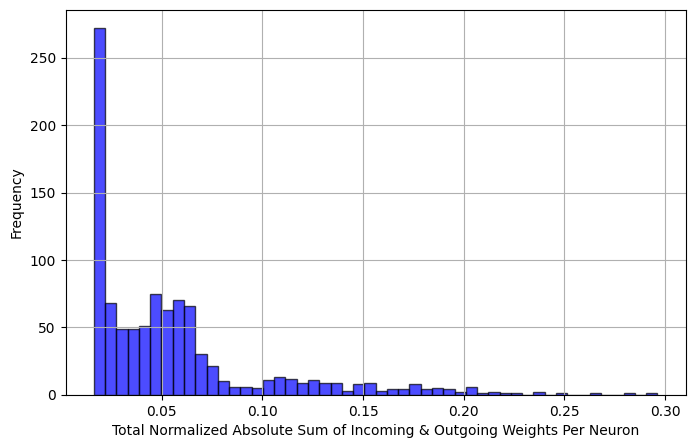

In [11]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Compute absolute sum of outgoing weights per neuron and normalize by the number of outgoing weights
fc1_outgoing = torch.sum(torch.abs(model.fc1.weight), dim=0) / model.fc1.weight.size(0)  # 784 input neurons
fc2_outgoing = torch.sum(torch.abs(model.fc2.weight), dim=0) / model.fc2.weight.size(0)  # 128 hidden neurons
fc3_outgoing = torch.sum(torch.abs(model.fc3.weight), dim=0) / model.fc3.weight.size(0)  # 64 hidden neurons

# Compute absolute sum of incoming weights per neuron and normalize by the number of incoming weights
fc1_incoming = torch.sum(torch.abs(model.fc1.weight), dim=1) / model.fc1.weight.size(1)  # 128 hidden neurons
fc2_incoming = torch.sum(torch.abs(model.fc2.weight), dim=1) / model.fc2.weight.size(1)  # 64 hidden neurons
fc3_incoming = torch.sum(torch.abs(model.fc3.weight), dim=1) / model.fc3.weight.size(1)  # 10 output neurons

# Compute total influence for each layer
l1 = fc1_outgoing  # Input layer (only outgoing)
l2 = fc1_incoming + fc2_outgoing  # First hidden layer
l3 = fc2_incoming + fc3_outgoing  # Second hidden layer
l4 = fc3_incoming  # Output layer (only incoming)

# Flatten and combine all values
all_total_sums = np.concatenate([
    l1.detach().cpu().numpy(),  # 784 input neurons
    l2.detach().cpu().numpy(),  # 128 first hidden neurons
    l3.detach().cpu().numpy(),  # 64 second hidden neurons
    l4.detach().cpu().numpy()   # 10 output neurons
])
print(len(all_total_sums))

# Plot histogram of total normalized absolute weights
plt.figure(figsize=(8, 5))
plt.hist(all_total_sums, bins=50, alpha=0.7, color="blue", edgecolor="black")
plt.xlabel("Total Normalized Absolute Sum of Incoming & Outgoing Weights Per Neuron")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


986


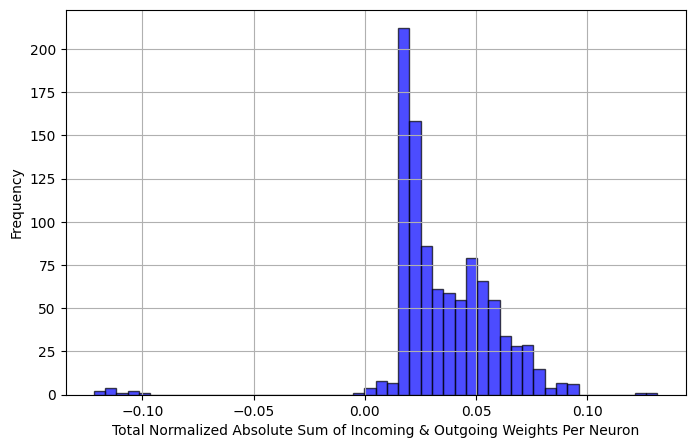

In [12]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Compute absolute sum of outgoing weights per neuron and normalize by the number of outgoing weights
fc1_outgoing = torch.sum(torch.abs(model.fc1.weight), dim=0) / model.fc1.weight.size(0)  # 784 input neurons
fc2_outgoing = torch.sum(torch.abs(model.fc2.weight), dim=0) / model.fc2.weight.size(0)  # 128 hidden neurons
fc3_outgoing = torch.sum(torch.abs(model.fc3.weight), dim=0) / model.fc3.weight.size(0)  # 64 hidden neurons

# Compute absolute sum of incoming weights per neuron and normalize by the number of incoming weights
fc1_incoming = torch.sum(torch.abs(model.fc1.weight), dim=1) / model.fc1.weight.size(1)  # 128 hidden neurons
fc2_incoming = torch.sum(torch.abs(model.fc2.weight), dim=1) / model.fc2.weight.size(1)  # 64 hidden neurons
fc3_incoming = torch.sum(torch.abs(model.fc3.weight), dim=1) / model.fc3.weight.size(1)  # 10 output neurons

# Compute total influence for each layer
l1 = fc1_outgoing  # Input layer (only outgoing)
l2 = -fc1_incoming + fc2_outgoing  # First hidden layer
l3 = -fc2_incoming + fc3_outgoing  # Second hidden layer
l4 = -fc3_incoming  # Output layer (only incoming)

# Flatten and combine all values
all_total_sums = np.concatenate([
    l1.detach().cpu().numpy(),  # 784 input neurons
    l2.detach().cpu().numpy(),  # 128 first hidden neurons
    l3.detach().cpu().numpy(),  # 64 second hidden neurons
    l4.detach().cpu().numpy()   # 10 output neurons
])
print(len(all_total_sums))

# Plot histogram of total normalized absolute weights
plt.figure(figsize=(8, 5))
plt.hist(all_total_sums, bins=50, alpha=0.7, color="blue", edgecolor="black")
plt.xlabel("Total Normalized Absolute Sum of Incoming & Outgoing Weights Per Neuron")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


In [13]:
import numpy as np

# Assuming all_total_sums is already defined
# Step 1: Compute the mean of the absolute values
mean_abs = np.mean(np.abs(all_total_sums))

# Step 2: Compute the abs(value) - mean for each element
modified_values = np.abs(all_total_sums) - mean_abs

# Step 3: Create a list of tuples (value, abs(value) - mean, original_index)
indexed_arr = [(val, mod_val, idx) for idx, (val, mod_val) in enumerate(zip(all_total_sums, modified_values))]

# Step 4: Sort the list by the absolute value of each element (keeping the sign intact)
sorted_arr = sorted(indexed_arr, key=lambda x: abs(x[0]), reverse=True)

# Step 5: Create the new list containing value, abs(value) - mean, original position, and new position
labeled_sorted_arr = [(val, mod_val, idx, rank) for rank, (val, mod_val, idx) in enumerate(sorted_arr)]

# Output the new list
for value, modified_value, original_index, new_position in labeled_sorted_arr:
    print(f"Value: {value}, Abs(Value) - Mean: {modified_value}, Original Position: {original_index}, New Position: {new_position}")


Value: 0.13151688873767853, Abs(Value) - Mean: 0.0937381461262703, Original Position: 965, New Position: 0
Value: 0.1249319314956665, Abs(Value) - Mean: 0.08715318888425827, Original Position: 930, New Position: 1
Value: -0.1217440590262413, Abs(Value) - Mean: 0.08396531641483307, Original Position: 985, New Position: 2
Value: -0.1184217780828476, Abs(Value) - Mean: 0.08064303547143936, Original Position: 976, New Position: 3
Value: -0.11645364761352539, Abs(Value) - Mean: 0.07867490500211716, Original Position: 982, New Position: 4
Value: -0.1161779910326004, Abs(Value) - Mean: 0.07839924842119217, Original Position: 980, New Position: 5
Value: -0.11284120380878448, Abs(Value) - Mean: 0.07506246119737625, Original Position: 977, New Position: 6
Value: -0.11250704526901245, Abs(Value) - Mean: 0.07472830265760422, Original Position: 981, New Position: 7
Value: -0.10770612210035324, Abs(Value) - Mean: 0.06992737948894501, Original Position: 984, New Position: 8
Value: -0.1060660481452941